<a href="https://colab.research.google.com/github/JuNYoUnGPaark/ML_2_Class/blob/main/WISDM_SEblock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/WISDM_ar_v1.1_raw.txt",
                header=None,
                names=['user_id', 'activity', 'timestamp', 'x', 'y', 'z'],
                on_bad_lines='skip')

df['z'] = df['z'].astype(str).str.replace(";", "", regex=False).astype(float)

df.head()

,user_id,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [3]:
print(df.isna().sum())
df = df.dropna()

user_id      0
activity     0
timestamp    0
x            0
y            0
z            1
dtype: int64


In [4]:
df_train = df[df['user_id'] <= 27].copy()
df_test = df[df['user_id'] > 27].copy()

print(df.shape)
print(df_train.shape)
print(df_test.shape)

(1086465, 6)
(801685, 6)
(284780, 6)


In [5]:
# Label Encoding
num_cols = ["x", "y", "z"]

le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["activity"])
df_test["label"]  = le.transform(df_test["activity"])

# RobustScaler
scaler = RobustScaler()
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_test[num_cols]  = scaler.transform(df_test[num_cols])

In [6]:
def create_sliding_windows_with_group(df, window_size=80, step_size=40):
    data, labels, groups = [], [], []
    values = df[["x", "y", "z"]].values
    acts   = df["label"].values
    users  = df["user_id"].values

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = values[start:end]
        label  = np.argmax(np.bincount(acts[start:end]))
        user   = users[start]

        data.append(window)
        labels.append(label)
        groups.append(user)

    return np.array(data), np.array(labels), np.array(groups)

X, y, groups = create_sliding_windows_with_group(df_train)
X_test, y_test, groups_test = create_sliding_windows_with_group(df_test)

# test 먼저 생성함
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)
test_ds  = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print("전체:", X.shape, y.shape, groups.shape)

전체: (20041, 80, 3) (20041,) (20041,)


In [7]:
gkf = GroupKFold(n_splits=5)

def get_fold_loaders(fold, batch_size=64):
    train_idx, val_idx = list(gkf.split(X, y, groups=groups))[fold]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val     = X[val_idx], y[val_idx]

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    val_ds   = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                             torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [8]:
class SEblock1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()  # B, C, L
        y = self.avg_pool(x).view(b, c)  # B, C, 1 -> B, C
        y = self.fc(y).view(b, c, 1)  # 다시 B, C, 1
        return x * y.expand_as(x)  # 채널별 재가중, expand_as:  y를 x와 사이즈를 맞추는 메서드

In [9]:
class Model(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        self.se = SEblock1D(channels=128, reduction=16)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 80, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, 80, 3) -> (batch,, 3, 80)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.se(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(num_classes=6).to(device)
print(device)
print(model)

cuda
Model(
  (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (se): SEblock1D(
    (avg_pool): AdaptiveAvgPool1d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=8, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=8, out_features=128, bias=False)
      (3): Sigmoid()
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=10240, out_features=6, bias=True)
)


In [11]:
def train_model(model, train_loader, val_loader, epochs=10):

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs+1):
        # --- Training ---
        model.train()
        train_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)

        train_acc = correct / total
        train_loss /= total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(yb).sum().item()
                val_total += yb.size(0)

        val_acc = val_correct / val_total
        val_loss /= val_total

        # --- 로그 저장 ---
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch:02d} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return history


===== Fold 1 =====
Epoch 01 | Train Loss: 0.4979, Acc: 0.8095 | Val Loss: 0.8738, Acc: 0.8049
Epoch 02 | Train Loss: 0.2210, Acc: 0.9248 | Val Loss: 1.4161, Acc: 0.6866
Epoch 03 | Train Loss: 0.1413, Acc: 0.9515 | Val Loss: 1.7127, Acc: 0.6904
Epoch 04 | Train Loss: 0.1248, Acc: 0.9649 | Val Loss: 1.9675, Acc: 0.6622
Epoch 05 | Train Loss: 0.1013, Acc: 0.9675 | Val Loss: 2.4592, Acc: 0.6873
Epoch 06 | Train Loss: 0.0823, Acc: 0.9721 | Val Loss: 1.4000, Acc: 0.7915
Epoch 07 | Train Loss: 0.1213, Acc: 0.9634 | Val Loss: 1.2031, Acc: 0.8041
Epoch 08 | Train Loss: 0.0662, Acc: 0.9793 | Val Loss: 1.2110, Acc: 0.8192
Epoch 09 | Train Loss: 0.0513, Acc: 0.9813 | Val Loss: 1.9540, Acc: 0.6768
Epoch 10 | Train Loss: 0.0504, Acc: 0.9823 | Val Loss: 1.5976, Acc: 0.7857
Epoch 11 | Train Loss: 0.0510, Acc: 0.9833 | Val Loss: 1.6733, Acc: 0.7665
Epoch 12 | Train Loss: 0.0419, Acc: 0.9846 | Val Loss: 2.1448, Acc: 0.6988
Epoch 13 | Train Loss: 0.0391, Acc: 0.9846 | Val Loss: 1.2544, Acc: 0.8251
Epoch

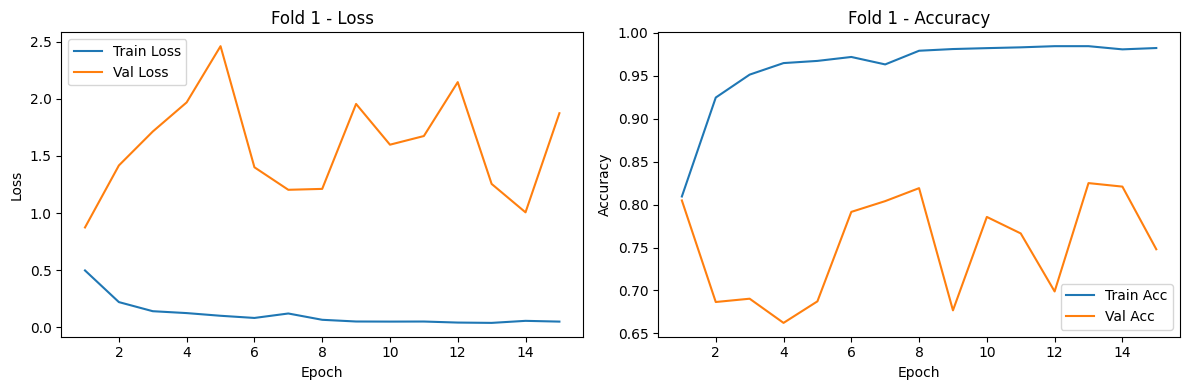

Fold 1 Accuracy: 0.7480

===== Fold 2 =====
Epoch 01 | Train Loss: 0.4958, Acc: 0.8236 | Val Loss: 0.9896, Acc: 0.6887
Epoch 02 | Train Loss: 0.2107, Acc: 0.9376 | Val Loss: 0.5975, Acc: 0.8232
Epoch 03 | Train Loss: 0.1584, Acc: 0.9543 | Val Loss: 0.7013, Acc: 0.8263
Epoch 04 | Train Loss: 0.1186, Acc: 0.9653 | Val Loss: 0.7300, Acc: 0.7985
Epoch 05 | Train Loss: 0.0999, Acc: 0.9710 | Val Loss: 0.8598, Acc: 0.7856
Epoch 06 | Train Loss: 0.0837, Acc: 0.9739 | Val Loss: 1.0921, Acc: 0.7648
Epoch 07 | Train Loss: 0.0800, Acc: 0.9742 | Val Loss: 0.9096, Acc: 0.8320
Epoch 08 | Train Loss: 0.0727, Acc: 0.9781 | Val Loss: 0.8874, Acc: 0.8318
Epoch 09 | Train Loss: 0.0670, Acc: 0.9799 | Val Loss: 1.0280, Acc: 0.8019
Epoch 10 | Train Loss: 0.0584, Acc: 0.9827 | Val Loss: 0.9438, Acc: 0.8342
Epoch 11 | Train Loss: 0.0611, Acc: 0.9813 | Val Loss: 1.0287, Acc: 0.8062
Epoch 12 | Train Loss: 0.0603, Acc: 0.9817 | Val Loss: 1.3098, Acc: 0.7856
Epoch 13 | Train Loss: 0.0554, Acc: 0.9841 | Val Loss: 1

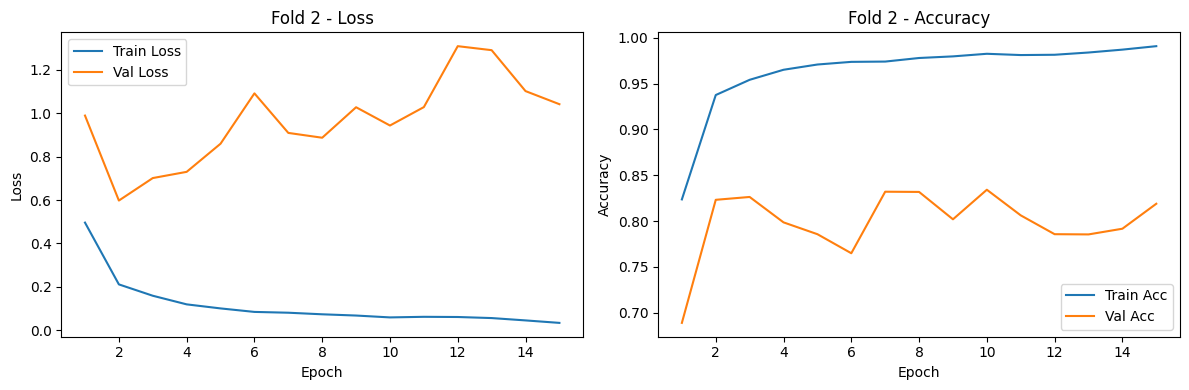

Fold 2 Accuracy: 0.8189

===== Fold 3 =====
Epoch 01 | Train Loss: 0.4563, Acc: 0.8283 | Val Loss: 0.9064, Acc: 0.7212
Epoch 02 | Train Loss: 0.2596, Acc: 0.9191 | Val Loss: 0.5070, Acc: 0.8251
Epoch 03 | Train Loss: 0.1629, Acc: 0.9491 | Val Loss: 0.8013, Acc: 0.7706
Epoch 04 | Train Loss: 0.1538, Acc: 0.9535 | Val Loss: 0.7129, Acc: 0.8059
Epoch 05 | Train Loss: 0.1134, Acc: 0.9631 | Val Loss: 0.5858, Acc: 0.8085
Epoch 06 | Train Loss: 0.0935, Acc: 0.9714 | Val Loss: 0.5838, Acc: 0.8413
Epoch 07 | Train Loss: 0.0954, Acc: 0.9724 | Val Loss: 0.5662, Acc: 0.8356
Epoch 08 | Train Loss: 0.0874, Acc: 0.9748 | Val Loss: 0.6946, Acc: 0.8300
Epoch 09 | Train Loss: 0.0673, Acc: 0.9803 | Val Loss: 1.0634, Acc: 0.7903
Epoch 10 | Train Loss: 0.0586, Acc: 0.9816 | Val Loss: 0.8106, Acc: 0.8149
Epoch 11 | Train Loss: 0.0601, Acc: 0.9838 | Val Loss: 0.9971, Acc: 0.8241
Epoch 12 | Train Loss: 0.0862, Acc: 0.9700 | Val Loss: 0.7459, Acc: 0.8067
Epoch 13 | Train Loss: 0.0493, Acc: 0.9838 | Val Loss: 0

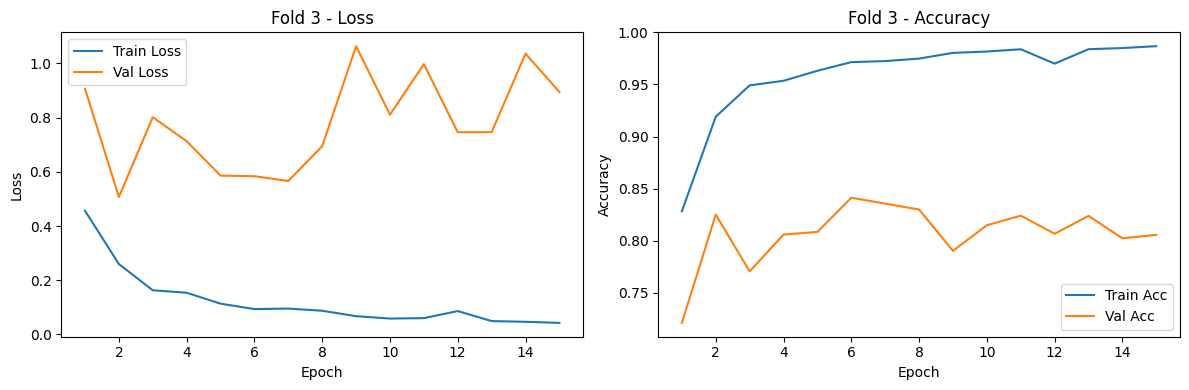

Fold 3 Accuracy: 0.8057

===== Fold 4 =====
Epoch 01 | Train Loss: 0.4554, Acc: 0.8256 | Val Loss: 1.2636, Acc: 0.7339
Epoch 02 | Train Loss: 0.2176, Acc: 0.9293 | Val Loss: 1.5744, Acc: 0.6720
Epoch 03 | Train Loss: 0.1510, Acc: 0.9546 | Val Loss: 1.7939, Acc: 0.6675
Epoch 04 | Train Loss: 0.1064, Acc: 0.9688 | Val Loss: 1.5928, Acc: 0.7534
Epoch 05 | Train Loss: 0.1339, Acc: 0.9602 | Val Loss: 1.6879, Acc: 0.7759
Epoch 06 | Train Loss: 0.0742, Acc: 0.9776 | Val Loss: 1.7016, Acc: 0.7183
Epoch 07 | Train Loss: 0.1016, Acc: 0.9686 | Val Loss: 2.3385, Acc: 0.7262
Epoch 08 | Train Loss: 0.0854, Acc: 0.9754 | Val Loss: 1.5751, Acc: 0.7685
Epoch 09 | Train Loss: 0.0855, Acc: 0.9732 | Val Loss: 2.0739, Acc: 0.7279
Epoch 10 | Train Loss: 0.0600, Acc: 0.9817 | Val Loss: 2.2416, Acc: 0.7646
Epoch 11 | Train Loss: 0.0938, Acc: 0.9714 | Val Loss: 2.6410, Acc: 0.7310
Epoch 12 | Train Loss: 0.0798, Acc: 0.9736 | Val Loss: 2.4396, Acc: 0.7692
Epoch 13 | Train Loss: 0.0739, Acc: 0.9774 | Val Loss: 2

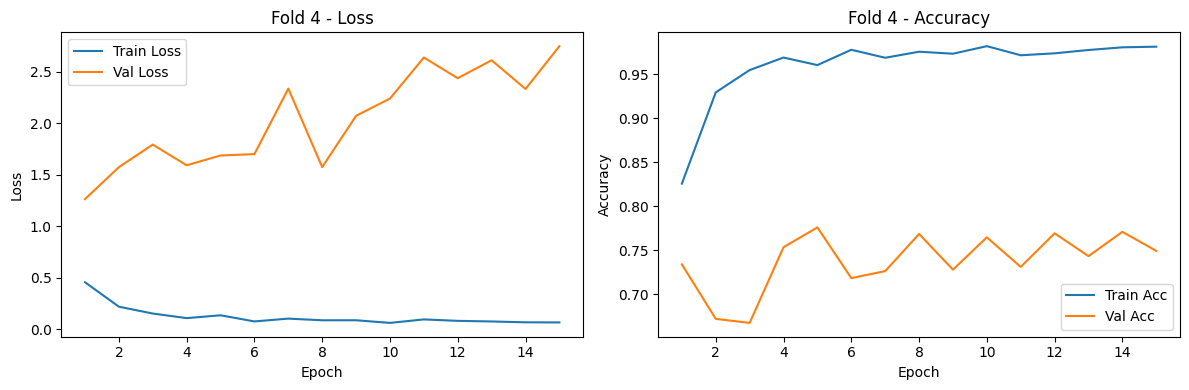

Fold 4 Accuracy: 0.7493

===== Fold 5 =====
Epoch 01 | Train Loss: 0.5752, Acc: 0.7714 | Val Loss: 0.6915, Acc: 0.7165
Epoch 02 | Train Loss: 0.2749, Acc: 0.9071 | Val Loss: 0.3140, Acc: 0.8926
Epoch 03 | Train Loss: 0.1943, Acc: 0.9395 | Val Loss: 0.2708, Acc: 0.9091
Epoch 04 | Train Loss: 0.1442, Acc: 0.9553 | Val Loss: 0.2599, Acc: 0.9073
Epoch 05 | Train Loss: 0.1201, Acc: 0.9627 | Val Loss: 0.1785, Acc: 0.9341
Epoch 06 | Train Loss: 0.1035, Acc: 0.9695 | Val Loss: 0.2429, Acc: 0.9132
Epoch 07 | Train Loss: 0.0936, Acc: 0.9717 | Val Loss: 0.2352, Acc: 0.9256
Epoch 08 | Train Loss: 0.0837, Acc: 0.9750 | Val Loss: 0.2310, Acc: 0.9238
Epoch 09 | Train Loss: 0.0771, Acc: 0.9760 | Val Loss: 0.2649, Acc: 0.9202
Epoch 10 | Train Loss: 0.0575, Acc: 0.9827 | Val Loss: 0.4754, Acc: 0.8898
Epoch 11 | Train Loss: 0.0496, Acc: 0.9847 | Val Loss: 0.2142, Acc: 0.9297
Epoch 12 | Train Loss: 0.0669, Acc: 0.9783 | Val Loss: 0.2012, Acc: 0.9369
Epoch 13 | Train Loss: 0.0549, Acc: 0.9834 | Val Loss: 0

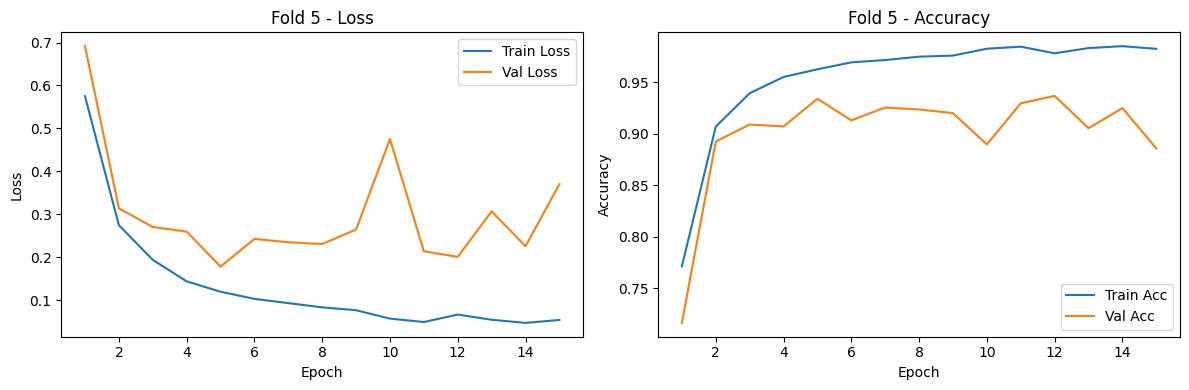

Fold 5 Accuracy: 0.8859

=== K-Fold 평균 정확도 ===
Mean Acc: 0.8015, Std: 0.0511


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_val_acc = 0.0
best_model_state = None
best_class_weights = None


fold_accs = []
for fold in range(5):
    print(f"\n===== Fold {fold+1} =====")
    train_loader, val_loader = get_fold_loaders(fold, batch_size=64)

    model = Model(num_classes=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 클래스 가중치 (train fold 기준)
    y_train_fold = np.array([y for _, y in train_loader.dataset])
    classes, counts = np.unique(y_train_fold, return_counts=True)
    weights = (counts.sum() / (len(classes) * counts)).astype(np.float32)
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # 학습 (히스토리 저장)
    history = train_model(model, train_loader, val_loader, epochs=15)

    # fold 최고 성능 기록
    val_acc = max(history["val_acc"])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        best_class_weights = class_weights

    # 시각화
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(12,4))

    # Loss 곡선
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(False)

    # Accuracy 곡선
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"Fold {fold+1} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(False)

    plt.tight_layout()
    plt.show()

    # fold 성능 저장
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(yb).sum().item()
            val_total += yb.size(0)
    acc = val_correct / val_total
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
    fold_accs.append(acc)

print("\n=== K-Fold 평균 정확도 ===")
print(f"Mean Acc: {np.mean(fold_accs):.4f}, Std: {np.std(fold_accs):.4f}")

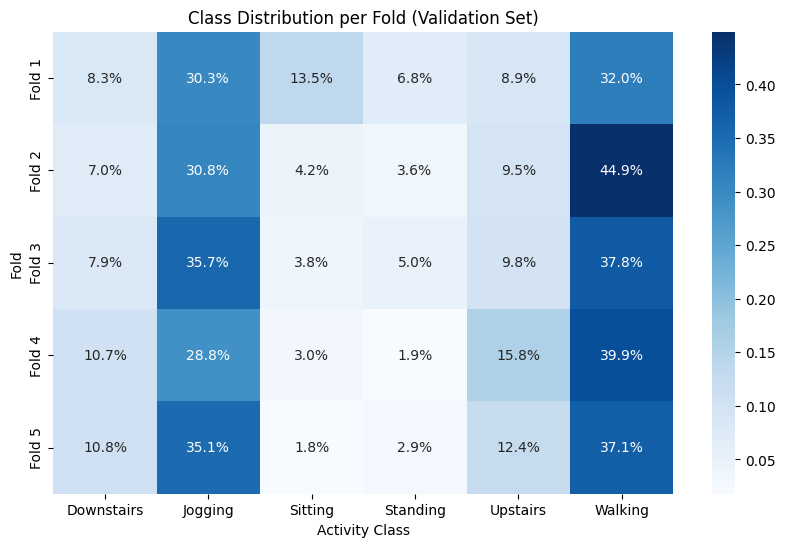

In [13]:
dist_per_fold = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    y_val = y[val_idx]
    counts = pd.Series(y_val).value_counts(normalize=True).sort_index()
    dist_per_fold.append(counts)

dist_df = pd.DataFrame(dist_per_fold).fillna(0)
dist_df.index = [f"Fold {i+1}" for i in range(len(dist_df))]
dist_df.columns = le.classes_  # activity 이름으로 열 바꾸기

plt.figure(figsize=(10,6))
sns.heatmap(dist_df, annot=True, fmt=".1%", cmap="Blues")
plt.title("Class Distribution per Fold (Validation Set)")
plt.ylabel("Fold")
plt.xlabel("Activity Class")
plt.show()

In [16]:
# test
def test_loop(model, test_loader, criterion, device="cpu"):
    model.eval()  # 평가 모드 (Dropout/BatchNorm 비활성화)
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():  # 테스트 시에는 gradient 계산 끔
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)

            # forward
            outputs = model(xb)
            loss = criterion(outputs, yb)

            # 손실 누적 (평균 내기 위해 샘플 수 곱해줌)
            test_loss += loss.item() * xb.size(0)

            # 예측값
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    avg_loss = test_loss / total
    acc = correct / total
    return avg_loss, acc, np.array(all_preds), np.array(all_labels)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(num_classes=6).to(device)
model.load_state_dict(best_model_state)

criterion = nn.CrossEntropyLoss(weight=best_class_weights)

test_loss, test_acc, all_preds, all_labels = test_loop(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 1.5207, Test Accuracy: 0.7829


In [19]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

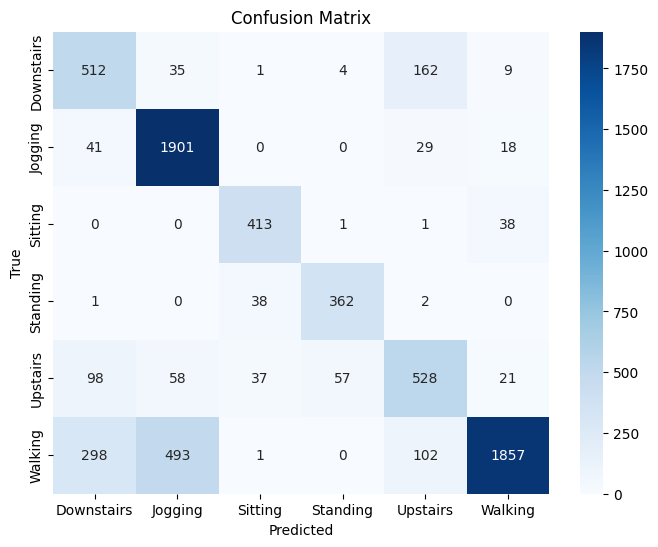

In [20]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print(classification_report(all_labels, all_preds, target_names=le.classes_))

              precision    recall  f1-score   support

  Downstairs       0.54      0.71      0.61       723
     Jogging       0.76      0.96      0.85      1989
     Sitting       0.84      0.91      0.88       453
    Standing       0.85      0.90      0.88       403
    Upstairs       0.64      0.66      0.65       799
     Walking       0.96      0.68      0.79      2751

    accuracy                           0.78      7118
   macro avg       0.77      0.80      0.78      7118
weighted avg       0.81      0.78      0.78      7118

